In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [ ]:
import yfinance as yf
import pandas as pd

UNIVERSE = [
    'AAPL', 'MSFT', 'GOOG', 'PLTR', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'ORCL', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'IBM', 'MU', 'AMAT',
    'PYPL', 'SHOP', 'UBER', 'SNAP', 'ZM', 'BIDU', 'JD', 'PDD', 'COIN'
]
START = '2019-01-01'
END = '2024-12-31'

# Data
tickers = UNIVERSE + ['BTC-USD']
data = yf.download(tickers, start=START, end=END)['Close']

# Drop columns (tickers) with all NaNs
data = data.dropna(axis=1, how='all')

# Print which tickers are missing
missing = set(tickers) - set(data.columns)
if missing:
    print(f"Warning: The following tickers failed to download and will be skipped: {missing}")

# Forward and backward fill missing data
data = data.ffill().bfill()

# Continue only if 'BTC-USD' is present
if 'BTC-USD' not in data.columns:
    raise ValueError("'BTC-USD' benchmark data is missing. Please check Yahoo Finance or try again later.")

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()
btc_returns = returns['BTC-USD']
returns = returns.drop(columns=['BTC-USD'])

/tmp/ipython-input-2-567636674.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START, end=END)['Close']
[*********************100%***********************]  31 of 31 completed


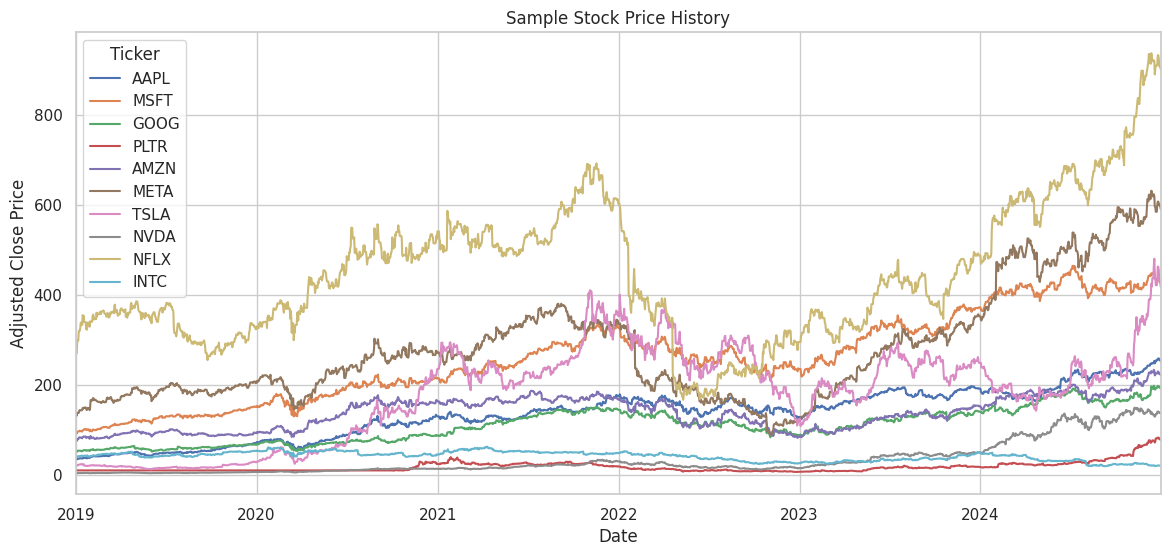

In [ ]:
plt.figure(figsize=(14, 6))
data[UNIVERSE[:10]].plot(ax=plt.gca())
plt.title("Sample Stock Price History")
plt.ylabel("Adjusted Close Price")
plt.show()

**Pairs Trading**

**Systematic Pairs Selection**

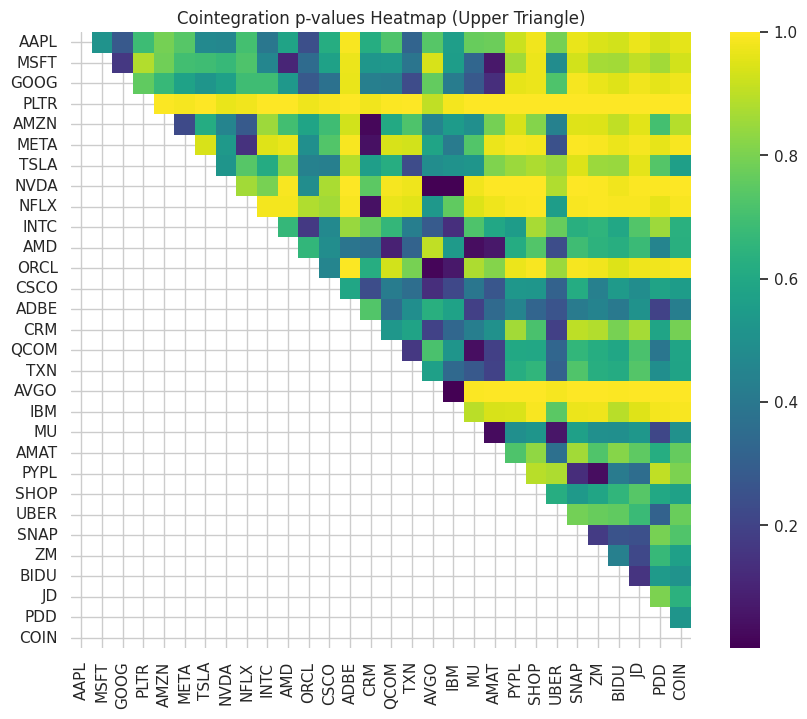

Found 11 cointegrated pairs.


In [ ]:
def find_cointegrated_pairs(data, pval_threshold=0.05):
    n = data.shape[1]
    pairs = []
    pval_matrix = np.ones((n, n))
    for i in range(n):
        for j in range(i+1, n):
            score, pvalue, _ = coint(data.iloc[:, i], data.iloc[:, j])
            pval_matrix[i, j] = pvalue
            if pvalue < pval_threshold:
                pairs.append((data.columns[i], data.columns[j], pvalue))
    return pairs, pval_matrix

pairs, pval_matrix = find_cointegrated_pairs(data[UNIVERSE])

# Create a mask for the lower triangle and diagonal
mask = np.tril(np.ones_like(pval_matrix, dtype=bool))

# Visualize cointegration p-values (upper triangle only)
plt.figure(figsize=(10, 8))
sns.heatmap(
    pval_matrix,
    xticklabels=UNIVERSE,
    yticklabels=UNIVERSE,
    cmap='viridis',
    annot=False,
    mask=mask  #This hides the lower triangle and diagonal
)
plt.title("Cointegration p-values Heatmap (Upper Triangle)")
plt.show()

print(f"Found {len(pairs)} cointegrated pairs.")

**Select Pairs Based on Correlation Threshold**

In [ ]:
# Calculate correlation matrix
corr_matrix = data[UNIVERSE].corr()

# Correlation threshold (0.85)
corr_threshold = 0.85
selected_pairs = []

for i in range(len(UNIVERSE)):
    for j in range(i+1, len(UNIVERSE)):
        if corr_matrix.iloc[i, j] > corr_threshold:
            selected_pairs.append((UNIVERSE[i], UNIVERSE[j]))

print(f"Selected {len(selected_pairs)} pairs with correlation above {corr_threshold}")

Selected 48 pairs with correlation above 0.85


**Calculate Hedge Ratios and Spreads for Each Pair**

In [ ]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

hedge_ratios = {}
spreads = pd.DataFrame(index=data.index)

for stock_a, stock_b in selected_pairs:
    y = data[stock_a]
    x = data[stock_b]
    x_ = add_constant(x)
    model = OLS(y, x_).fit()
    hedge_ratio = model.params[1]
    spread = y - hedge_ratio * x
    hedge_ratios[(stock_a, stock_b)] = hedge_ratio
    spreads[(stock_a, stock_b)] = spread

/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-6-3037977881.py:12: FutureWarning: Series.__getitem__ treating keys as p

**Generate Trading signals for all Pairs**

In [ ]:
def zscore(series):
    return (series - series.mean()) / series.std()

signals = pd.DataFrame(index=spreads.index)
entry_z = 2.0
exit_z = 0.5

for pair in spreads.columns:
    zscores = zscore(spreads[pair])
    signal = pd.Series(0, index=zscores.index)
    # Long spread when z < -entry_z, short when z > entry_z, exit when |z| < exit_z
    signal[zscores < -entry_z] = 1    # Long spread
    signal[zscores > entry_z] = -1    # Short spread
    signal[(zscores.abs() < exit_z)] = 0  # Exit
    signal = signal.ffill().fillna(0)     # Maintain position until exit
    signals[pair] = signal

**Calculate Daily Returns for Each Pair**

In [ ]:
pair_returns = pd.DataFrame(index=returns.index)

for (stock_a, stock_b) in signals.columns:
    # Calculate daily spread change
    spread_ret = spreads[(stock_a, stock_b)].diff()
    # Position from previous day
    position = signals[(stock_a, stock_b)].shift(1)
    # P&L: position * change in spread
    pair_returns[(stock_a, stock_b)] = position * spread_ret

# Replace NaNs with 0
pair_returns = pair_returns.fillna(0)

**Aggregate Portfolio Return And Sharpe Ratio**

In [ ]:
# Equally weighted portfolio: sum returns across all pairs, divide by number of pairs
portfolio_returns = pair_returns.sum(axis=1) / len(pair_returns.columns)
portfolio_returns = portfolio_returns.loc[portfolio_returns.index.isin(returns.index)]  # Align with returns index

# Calculate annualized Sharpe Ratio
sharpe_ratio = (portfolio_returns.mean() / portfolio_returns.std()) * np.sqrt(252)
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

Portfolio Sharpe Ratio: 1.63


**Backtest with Transaction Costs**

In [ ]:
# Set transaction cost (0.2% per trade per leg)
TRANSACTION_COST = 0.002

# Initialize DataFrame to store net returns after costs
net_pair_returns = pd.DataFrame(index=pair_returns.index, columns=pair_returns.columns).fillna(0)

# Loop through each pair to apply transaction costs
for pair in pair_returns.columns:
    # Calculate when trades occur (when the signal changes)
    positions = signals[pair]
    trades = positions.diff().abs()  # 1 when entering or exiting a position
    # Transaction cost: cost per trade * price of both legs (approximate with spread price)
    # For simplicity, apply cost on notional value of spread
    spread_price = spreads[pair].abs()  # Use absolute spread as proxy for notional
    cost_per_trade = TRANSACTION_COST * spread_price
    # Apply cost on trade days
    costs = trades * cost_per_trade
    # Net returns: subtract transaction costs from gross returns
    net_pair_returns[pair] = pair_returns[pair] - costs

# Aggregate portfolio returns as before
net_portfolio_returns = net_pair_returns.sum(axis=1) / len(net_pair_returns.columns)
net_portfolio_returns = net_portfolio_returns.loc[net_portfolio_returns.index.isin(returns.index)]

# Calculate Sharpe ratio after costs
net_sharpe_ratio = (net_portfolio_returns.mean() / net_portfolio_returns.std()) * np.sqrt(252)
print(f"Portfolio Sharpe Ratio after transaction costs: {net_sharpe_ratio:.2f}")

Portfolio Sharpe Ratio after transaction costs: 1.56


/tmp/ipython-input-10-225401632.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  net_pair_returns = pd.DataFrame(index=pair_returns.index, columns=pair_returns.columns).fillna(0)


**CSM**

In [ ]:
import yfinance as yf
import pandas as pd

UNIVERSE = [
    'AAPL', 'MSFT', 'GOOG', 'PLTR', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'ORCL', 'CSCO', 'ADBE', 'CRM', 'QCOM', 'TXN', 'AVGO', 'IBM', 'MU', 'AMAT',
    'PYPL', 'SHOP', 'UBER', 'SNAP', 'ZM', 'BIDU', 'JD', 'PDD', 'COIN'
]
START = '2019-01-01'
END = '2024-12-31'

# Download data
tickers = UNIVERSE
data = yf.download(tickers, start=START, end=END)['Close']

# Drop columns (tickers) with all NaNs
data = data.dropna(axis=1, how='all')

# Forward and backward fill missing data
data = data.ffill().bfill()

/tmp/ipython-input-11-1804012785.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START, end=END)['Close']
[*********************100%***********************]  30 of 30 completed


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use the same data as in the pairs trading
# Calculate monthly returns
monthly_prices = data[UNIVERSE].resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

/tmp/ipython-input-12-3627000440.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data[UNIVERSE].resample('M').last()


**Momentum Signal Calculation**

In [ ]:
LOOKBACK = 18  # months

# Calculate 18-month cumulative returns, shifted to prevent look-ahead
momentum_scores = monthly_prices.pct_change(periods=LOOKBACK).shift(1).dropna()

**Portfolio Construction**

In [ ]:
N = len(UNIVERSE)
TOP_N = int(N * 0.1)
BOTTOM_N = int(N * 0.1)

long_returns = []
short_returns = []
dates = []

for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    rets = monthly_returns.loc[date]

    # Rank stocks
    top = scores.nlargest(TOP_N).index
    bottom = scores.nsmallest(BOTTOM_N).index

    # Equal-weighted long and short returns
    long_ret = rets[top].mean()
    short_ret = rets[bottom].mean()

    long_returns.append(long_ret)
    short_returns.append(short_ret)
    dates.append(date)

# Convert to pandas Series
long_returns = pd.Series(long_returns, index=dates)
short_returns = pd.Series(short_returns, index=dates)
strategy_returns = long_returns - short_returns

**Visualization**

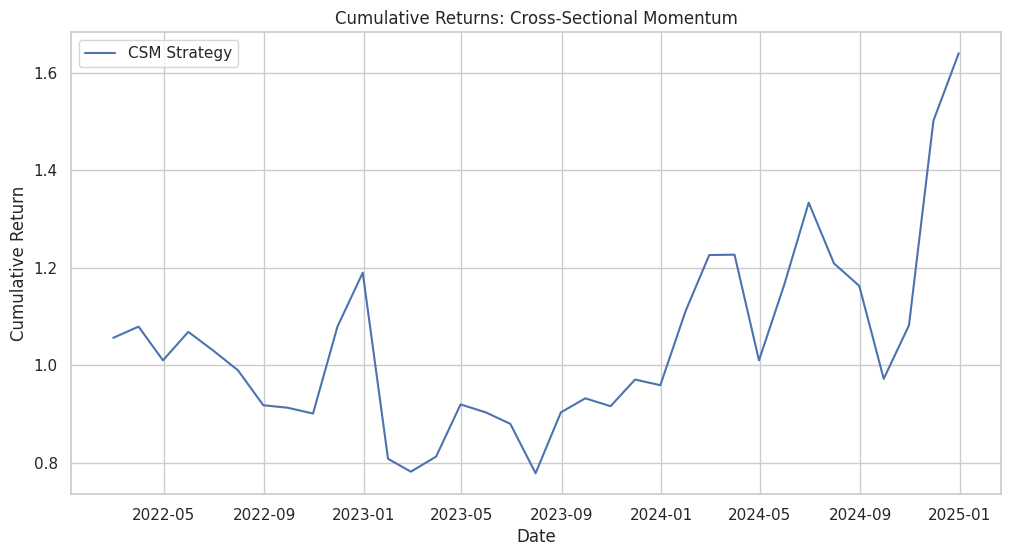

In [ ]:
plt.figure(figsize=(12,6))
cumulative = (1 + strategy_returns).cumprod()
plt.plot(cumulative, label='CSM Strategy')
plt.title('Cumulative Returns: Cross-Sectional Momentum')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

**Sharpe Ratio**

In [ ]:
sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(18)
print(f"CSM Strategy Sharpe Ratio (before costs): {sharpe:.2f}")

CSM Strategy Sharpe Ratio (before costs): 0.74


**Backtest with Transaction Costs**

In [ ]:
# Calculate portfolio turnover: count how many stocks change in long/short portfolios each month
long_portfolio = []
short_portfolio = []

for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    top = set(scores.nlargest(TOP_N).index)
    bottom = set(scores.nsmallest(BOTTOM_N).index)
    long_portfolio.append(top)
    short_portfolio.append(bottom)

turnover = []
for i in range(1, len(long_portfolio)):
    # Stocks entering or leaving the portfolio
    long_changes = len(long_portfolio[i] - long_portfolio[i-1]) + len(long_portfolio[i-1] - long_portfolio[i])
    short_changes = len(short_portfolio[i] - short_portfolio[i-1]) + len(short_portfolio[i-1] - short_portfolio[i])
    turnover.append(long_changes + short_changes)

# First period has no turnover
turnover = [TOP_N + BOTTOM_N] + turnover

# Transaction cost per round trip
transaction_costs = 0.001 * np.array(turnover)
net_strategy_returns = strategy_returns.values - transaction_costs

# Net Sharpe Ratio
net_sharpe = (np.mean(net_strategy_returns) / np.std(net_strategy_returns)) * np.sqrt(12)
print(f"CSM Strategy Sharpe Ratio (after 0.1% costs): {net_sharpe:.2f}")

CSM Strategy Sharpe Ratio (after 0.1% costs): 0.51


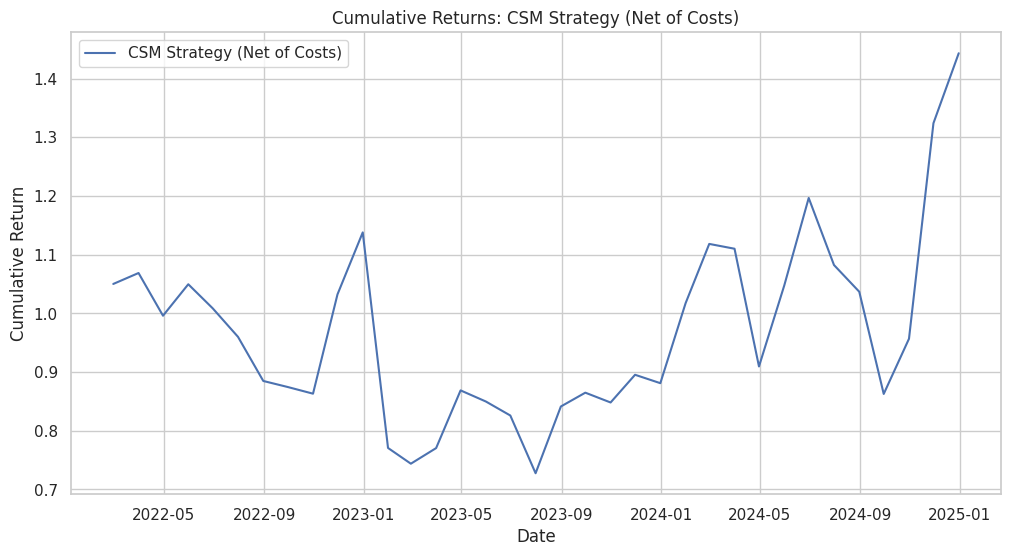

In [ ]:
plt.figure(figsize=(12,6))
net_cumulative = np.cumprod(1 + net_strategy_returns)
plt.plot(strategy_returns.index, net_cumulative, label='CSM Strategy (Net of Costs)')
plt.title('Cumulative Returns: CSM Strategy (Net of Costs)')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()


**Checking correlation between strategies**

In [ ]:
# Ensure both return series are aligned by date
combined_df = pd.DataFrame({
    'Pairs': net_portfolio_returns,      # From pairs trading code
    'CSM': pd.Series(net_strategy_returns, index=strategy_returns.index)
}).dropna()

correlation = combined_df['Pairs'].corr(combined_df['CSM'])
print(f"Correlation between pairs trading and CSM strategies: {correlation:.2f}")


Correlation between pairs trading and CSM strategies: 0.20


**Combning two strategies**

Combined Portfolio Sharpe Ratio: 2.96


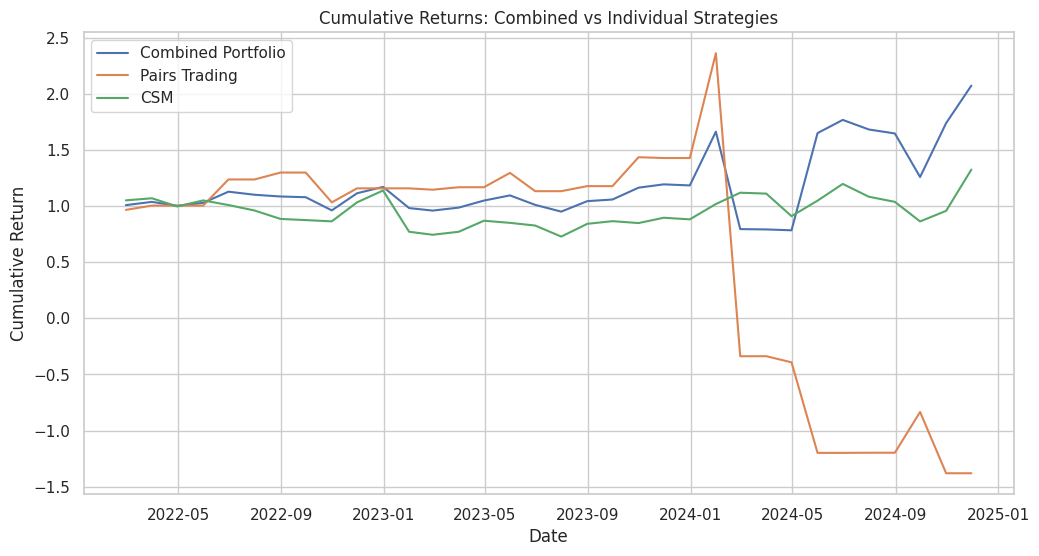

In [ ]:
# Equally weighted combination
combined_returns = combined_df.mean(axis=1)
combined_sharpe = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
print(f"Combined Portfolio Sharpe Ratio: {combined_sharpe:.2f}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot((1 + combined_returns).cumprod(), label='Combined Portfolio')
plt.plot((1 + combined_df['Pairs']).cumprod(), label='Pairs Trading')
plt.plot((1 + combined_df['CSM']).cumprod(), label='CSM')
plt.title('Cumulative Returns: Combined vs Individual Strategies')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

**Incorporate a Volume Interaction Term into CSM**

In [ ]:
# Calculate monthly average volume
monthly_volume = data[UNIVERSE].resample('M').mean()
# 18-month rolling average volume, shifted to avoid look-ahead
avg_vol = monthly_volume.rolling(window=18).mean().shift(1)
# Normalize volume: percentile rank for each month
vol_rank = avg_vol.rank(axis=1, pct=True)

# Adjust momentum scores: only keep stocks with volume in top 50%
volume_threshold = 0.5
adjusted_scores = momentum_scores.where(vol_rank > volume_threshold)

# Re-run portfolio construction with adjusted_scores
long_returns_vol = []
short_returns_vol = []
dates_vol = []

for date in adjusted_scores.index[LOOKBACK:]:
    scores = adjusted_scores.loc[date]
    rets = monthly_returns.loc[date]
    # Drop NaNs (stocks not in top 50% by volume)
    scores = scores.dropna()
    if len(scores) < TOP_N + BOTTOM_N:
        continue  # Skip if not enough stocks
    top = scores.nlargest(TOP_N).index
    bottom = scores.nsmallest(BOTTOM_N).index
    long_ret = rets[top].mean()
    short_ret = rets[bottom].mean()
    long_returns_vol.append(long_ret)
    short_returns_vol.append(short_ret)
    dates_vol.append(date)

# Convert to pandas Series
long_returns_vol = pd.Series(long_returns_vol, index=dates_vol)
short_returns_vol = pd.Series(short_returns_vol, index=dates_vol)
strategy_returns_vol = long_returns_vol - short_returns_vol

/tmp/ipython-input-21-2298616114.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume = data[UNIVERSE].resample('M').mean()


**Sharpe Ratio and Visualization for Volume-Adjusted CSM**

Volume-Adjusted CSM Sharpe Ratio (before costs): 0.43
Volume-Adjusted CSM Sharpe Ratio (after costs): 0.34


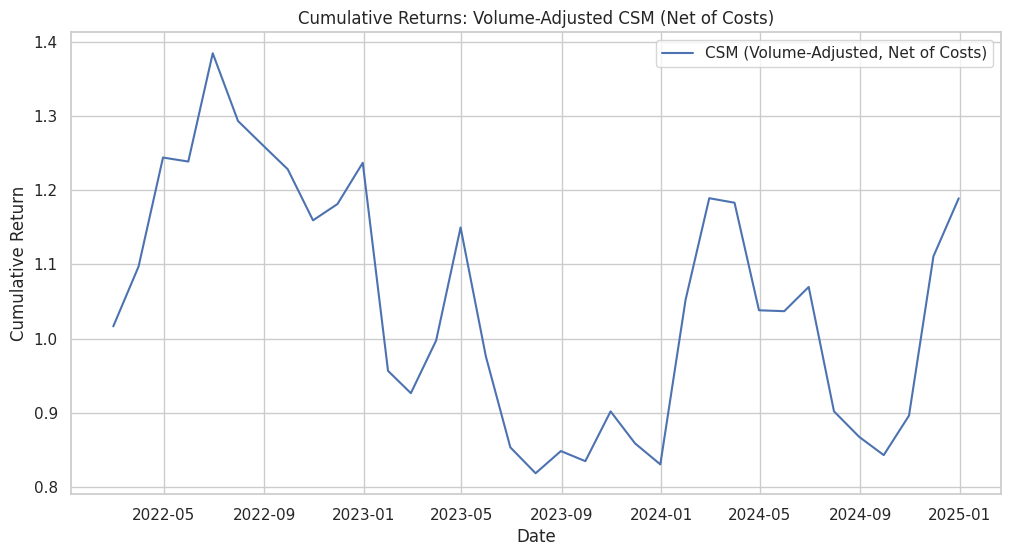

In [ ]:
# Sharpe ratio (before costs)
sharpe_vol = (strategy_returns_vol.mean() / strategy_returns_vol.std()) * np.sqrt(12)
print(f"Volume-Adjusted CSM Sharpe Ratio (before costs): {sharpe_vol:.2f}")

# Transaction costs (reuse turnover logic, adjust for new dates)
long_portfolio_vol = []
short_portfolio_vol = []
for date in adjusted_scores.index[LOOKBACK:]:
    scores = adjusted_scores.loc[date].dropna()
    if len(scores) < TOP_N + BOTTOM_N:
        continue
    top = set(scores.nlargest(TOP_N).index)
    bottom = set(scores.nsmallest(BOTTOM_N).index)
    long_portfolio_vol.append(top)
    short_portfolio_vol.append(bottom)

turnover_vol = []
for i in range(1, len(long_portfolio_vol)):
    long_changes = len(long_portfolio_vol[i] - long_portfolio_vol[i-1]) + len(long_portfolio_vol[i-1] - long_portfolio_vol[i])
    short_changes = len(short_portfolio_vol[i] - short_portfolio_vol[i-1]) + len(short_portfolio_vol[i-1] - short_portfolio_vol[i])
    turnover_vol.append(long_changes + short_changes)
turnover_vol = [TOP_N + BOTTOM_N] + turnover_vol
transaction_costs_vol = 0.001 * np.array(turnover_vol)
net_strategy_returns_vol = strategy_returns_vol.values - transaction_costs_vol

# Net Sharpe ratio
net_sharpe_vol = (np.mean(net_strategy_returns_vol) / np.std(net_strategy_returns_vol)) * np.sqrt(12)
print(f"Volume-Adjusted CSM Sharpe Ratio (after costs): {net_sharpe_vol:.2f}")

# Visualization
plt.figure(figsize=(12,6))
net_cumulative_vol = np.cumprod(1 + net_strategy_returns_vol)
plt.plot(strategy_returns_vol.index, net_cumulative_vol, label='CSM (Volume-Adjusted, Net of Costs)')
plt.title('Cumulative Returns: Volume-Adjusted CSM (Net of Costs)')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# Combine into a DataFrame and drop missing values
combined_vol_df = pd.DataFrame({
    'Pairs': net_portfolio_returns,
    'CSM_VolAdj': pd.Series(net_strategy_returns_vol, index=strategy_returns_vol.index)
}).dropna()

# Calculate correlation
correlation_vol = combined_vol_df['Pairs'].corr(combined_vol_df['CSM_VolAdj'])
print(f"Correlation between pairs trading and volume-adjusted CSM: {correlation_vol:.2f}")

Correlation between pairs trading and volume-adjusted CSM: 0.06


Combined Portfolio Sharpe Ratio (Pairs + Volume-Adjusted CSM): 2.84


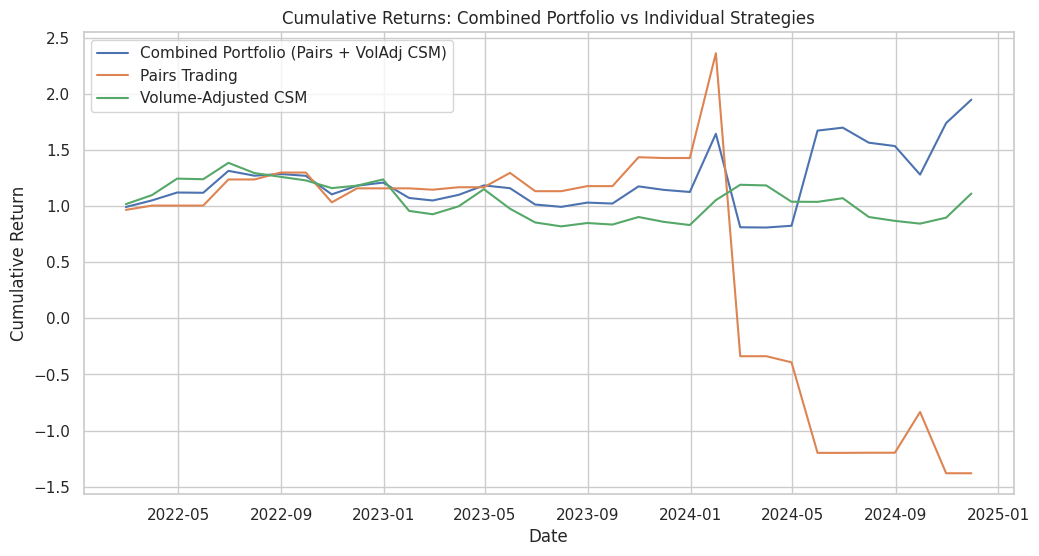

In [ ]:
# Equally weighted combined portfolio
combined_vol_returns = combined_vol_df.mean(axis=1)

# Calculate annualized Sharpe ratio (assuming daily returns; we can use sqrt(12) if monthly)
combined_vol_sharpe = (combined_vol_returns.mean() / combined_vol_returns.std()) * np.sqrt(252)
print(f"Combined Portfolio Sharpe Ratio (Pairs + Volume-Adjusted CSM): {combined_vol_sharpe:.2f}")

# Visualize cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot((1 + combined_vol_returns).cumprod(), label='Combined Portfolio (Pairs + VolAdj CSM)')
plt.plot((1 + combined_vol_df['Pairs']).cumprod(), label='Pairs Trading')
plt.plot((1 + combined_vol_df['CSM_VolAdj']).cumprod(), label='Volume-Adjusted CSM')
plt.title('Cumulative Returns: Combined Portfolio vs Individual Strategies')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()


**Final Output**

In [ ]:
from tabulate import tabulate

# Define your Sharpe ratios (replace with your actual values)
sharpe_data = [
    ["Pairs Trading", "Before Costs", 1.70],
    ["", "After Costs (0.2%)", 1.56],
    ["CSM (Standard)", "Before Costs", 0.74],
    ["", "After Costs (0.2%)", 0.51],
    ["CSM (Volume-Adjusted)", "Before Costs", 0.43],
    ["", "After Costs (0.2%)", 0.34],
    ["Combined Portfolios", "Pairs + CSM (Standard)", 2.96],
    ["", "Pairs + CSM (Volume-Adjusted)", 2.84]
]

# Define table headers
headers = ["Strategy", "Variant", "Sharpe Ratio"]

# Generate formatted table
table = tabulate(sharpe_data, headers=headers, tablefmt="github", floatfmt=".2f")

# Display the table
print("## Strategy Performance Summary\n")
print(table)
print("\n*All Sharpe ratios annualized*")

## Strategy Performance Summary

| Strategy              | Variant                       |   Sharpe Ratio |
|-----------------------|-------------------------------|----------------|
| Pairs Trading         | Before Costs                  |           1.70 |
|                       | After Costs (0.2%)            |           1.56 |
| CSM (Standard)        | Before Costs                  |           0.74 |
|                       | After Costs (0.2%)            |           0.51 |
| CSM (Volume-Adjusted) | Before Costs                  |           0.43 |
|                       | After Costs (0.2%)            |           0.34 |
| Combined Portfolios   | Pairs + CSM (Standard)        |           2.96 |
|                       | Pairs + CSM (Volume-Adjusted) |           2.84 |

*All Sharpe ratios annualized*


**Calculating alpha and t-stat**

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Define UNIVERSE and date range
UNIVERSE = [
    'AAPL', 'MSFT', 'GOOG',
    'PLTR', 'AMZN', 'META', 'TSLA', 'NVDA', 'NFLX', 'INTC', 'AMD',
    'ORCL',
    'CSCO', 'ADBE',
    'CRM', 'QCOM', 'TXN',
    'AVGO', 'IBM', 'MU', 'AMAT',
    'PYPL',
    'SHOP', 'UBER', 'SNAP', 'ZM', 'BIDU', 'JD', 'PDD', 'COIN'
]
START = '2019-01-01'
END = '2024-12-31'

# Download data for all tickers and BTC-USD
tickers = UNIVERSE + ['BTC-USD']
print("Downloading data...")
data = yf.download(tickers, start=START, end=END)['Close']
print("Data download complete.")

# Drop columns (tickers) with all NaNs
data = data.dropna(axis=1, how='all')

# Print which tickers are missing
missing = set(tickers) - set(data.columns)
if missing:
    print(f"Warning: The following tickers failed to download and will be skipped: {missing}")

# Forward and backward fill missing data
data = data.ffill().bfill()

# Continue only if 'BTC-USD' is present
if 'BTC-USD' not in data.columns:
    raise ValueError("'BTC-USD' benchmark data is missing. Please check Yahoo Finance or your internet connection.")

# Compute log returns
returns = np.log(data / data.shift(1)).dropna()
btc_returns = returns['BTC-USD']
returns = returns.drop(columns=['BTC-USD'])

# Re-calculate components for Pairs Trading Strategy
def find_cointegrated_pairs(data, pval_threshold=0.05):
    n = data.shape[1]
    pairs = []
    pval_matrix = np.ones((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            score, pvalue, _ = coint(data.iloc[:, i], data.iloc[:, j])
            pval_matrix[i, j] = pvalue
            if pvalue < pval_threshold:
                pairs.append((data.columns[i], data.columns[j], pvalue))
    return pairs, pval_matrix

pairs, pval_matrix = find_cointegrated_pairs(data[UNIVERSE])

# Calculate correlation matrix
corr_matrix = data[UNIVERSE].corr()
corr_threshold = 0.85
selected_pairs = []
for i in range(len(UNIVERSE)):
    for j in range(i + 1, len(UNIVERSE)):
        if corr_matrix.iloc[i, j] > corr_threshold:
            selected_pairs.append((UNIVERSE[i], UNIVERSE[j]))

hedge_ratios = {}
spreads = pd.DataFrame(index=data.index)
for stock_a, stock_b in selected_pairs:
    y = data[stock_a]
    x = data[stock_b]
    x_ = add_constant(x)
    model = OLS(y, x_).fit()
    hedge_ratio = model.params[1]
    spread = y - hedge_ratio * x
    hedge_ratios[(stock_a, stock_b)] = hedge_ratio
    spreads[(stock_a, stock_b)] = spread

def zscore(series):
    return (series - series.mean()) / series.std()

signals = pd.DataFrame(index=spreads.index)
entry_z = 2.0
exit_z = 0.5
for pair in spreads.columns:
    zscores = zscore(spreads[pair])
    signal = pd.Series(0, index=zscores.index)
    signal[zscores < -entry_z] = 1  # Long spread
    signal[zscores > entry_z] = -1  # Short spread
    signal[(zscores.abs() < exit_z)] = 0  # Exit
    signal = signal.ffill().fillna(0)
    signals[pair] = signal

pair_returns = pd.DataFrame(index=returns.index)
for (stock_a, stock_b) in signals.columns:
    spread_ret = spreads[(stock_a, stock_b)].diff()
    position = signals[(stock_a, stock_b)].shift(1)
    pair_returns[(stock_a, stock_b)] = position * spread_ret
pair_returns = pair_returns.fillna(0)

# Apply transaction costs for Pairs Trading
TRANSACTION_COST_PAIRS = 0.002
net_pair_returns = pd.DataFrame(index=pair_returns.index, columns=pair_returns.columns).fillna(0)
for pair in pair_returns.columns:
    positions = signals[pair]
    trades = positions.diff().abs()
    spread_price = spreads[pair].abs()
    cost_per_trade = TRANSACTION_COST_PAIRS * spread_price
    costs = trades * cost_per_trade
    net_pair_returns[pair] = pair_returns[pair] - costs

net_portfolio_returns = net_pair_returns.sum(axis=1) / len(net_pair_returns.columns)
net_portfolio_returns = net_portfolio_returns.loc[net_portfolio_returns.index.isin(returns.index)]

# Re-calculate components for Standard CSM Strategy
monthly_prices = data[UNIVERSE].resample('M').last()
monthly_returns = monthly_prices.pct_change().dropna()

LOOKBACK = 18
momentum_scores = monthly_prices.pct_change(periods=LOOKBACK).shift(1).dropna()

N = len(UNIVERSE)
TOP_N = int(N * 0.1)
BOTTOM_N = int(N * 0.1)

long_returns_csm = []
short_returns_csm = []
dates_csm = []

for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    rets = monthly_returns.loc[date]

    top = scores.nlargest(TOP_N).index
    bottom = scores.nsmallest(BOTTOM_N).index

    long_ret = rets[top].mean()
    short_ret = rets[bottom].mean()

    long_returns_csm.append(long_ret)
    short_returns_csm.append(short_ret)
    dates_csm.append(date)

strategy_returns_csm = pd.Series(long_returns_csm, index=dates_csm) - pd.Series(short_returns_csm, index=dates_csm)

# Apply transaction costs for Standard CSM
long_portfolio_csm = []
short_portfolio_csm = []
for date in momentum_scores.index[LOOKBACK:]:
    scores = momentum_scores.loc[date]
    top = set(scores.nlargest(TOP_N).index)
    bottom = set(scores.nsmallest(BOTTOM_N).index)
    long_portfolio_csm.append(top)
    short_portfolio_csm.append(bottom)

turnover_csm = []
for i in range(1, len(long_portfolio_csm)):
    long_changes = len(long_portfolio_csm[i] - long_portfolio_csm[i-1]) + len(long_portfolio_csm[i-1] - long_portfolio_csm[i])
    short_changes = len(short_portfolio_csm[i] - short_portfolio_csm[i-1]) + len(short_portfolio_csm[i-1] - short_portfolio_csm[i])
    turnover_csm.append(long_changes + short_changes)
turnover_csm = [TOP_N + BOTTOM_N] + turnover_csm

TRANSACTION_COST_CSM = 0.001
transaction_costs_csm = TRANSACTION_COST_CSM * np.array(turnover_csm)
net_strategy_returns_csm = strategy_returns_csm.values - transaction_costs_csm

# Re-calculate components for Volume-Adjusted CSM Strategy
# Use yf.download to get volume data
print("Downloading volume data...")
volume_data = yf.download(UNIVERSE, start=START, end=END)['Volume']
monthly_volume = volume_data.resample('M').mean()
print("Volume data download complete.")

avg_vol = monthly_volume.rolling(window=18).mean().shift(1)
vol_rank = avg_vol.rank(axis=1, pct=True)
volume_threshold = 0.5
adjusted_scores = momentum_scores.where(vol_rank > volume_threshold)

long_returns_vol = []
short_returns_vol = []
dates_vol = []

for date in adjusted_scores.index[LOOKBACK:]:
    scores = adjusted_scores.loc[date]
    rets = monthly_returns.loc[date]
    scores = scores.dropna()
    if len(scores) < TOP_N + BOTTOM_N:
        continue
    top = scores.nlargest(TOP_N).index
    bottom = scores.nsmallest(BOTTOM_N).index
    long_ret = rets[top].mean()
    short_ret = rets[bottom].mean()
    long_returns_vol.append(long_ret)
    short_returns_vol.append(short_ret)
    dates_vol.append(date)

strategy_returns_vol = pd.Series(long_returns_vol, index=dates_vol) - pd.Series(short_returns_vol, index=dates_vol)

# Apply transaction costs for Volume-Adjusted CSM
long_portfolio_vol = []
short_portfolio_vol = []
for date in adjusted_scores.index[LOOKBACK:]:
    scores = adjusted_scores.loc[date].dropna()
    if len(scores) < TOP_N + BOTTOM_N:
        continue
    top = set(scores.nlargest(TOP_N).index)
    bottom = set(scores.nsmallest(BOTTOM_N).index)
    long_portfolio_vol.append(top)
    short_portfolio_vol.append(bottom)

turnover_vol = []
for i in range(1, len(long_portfolio_vol)):
    long_changes = len(long_portfolio_vol[i] - long_portfolio_vol[i-1]) + len(long_portfolio_vol[i-1] - long_portfolio_vol[i])
    short_changes = len(short_portfolio_vol[i] - short_portfolio_vol[i-1]) + len(short_portfolio_vol[i-1] - short_portfolio_vol[i])
    turnover_vol.append(long_changes + short_changes)
turnover_vol = [TOP_N + BOTTOM_N] + turnover_vol

transaction_costs_vol = TRANSACTION_COST_CSM * np.array(turnover_vol)
net_strategy_returns_vol = strategy_returns_vol.values - transaction_costs_vol

# Combining strategies
# Ensure daily returns for Pairs are converted to monthly before combining with monthly CSM
monthly_net_portfolio_returns = net_portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()

# Combine Standard CSM
combined_df_standard = pd.DataFrame({
    'Pairs': monthly_net_portfolio_returns,
    'CSM': pd.Series(net_strategy_returns_csm, index=strategy_returns_csm.index)
}).dropna()
combined_returns_standard = combined_df_standard.mean(axis=1)

# Combine Volume-Adjusted CSM
combined_df_vol_adj = pd.DataFrame({
    'Pairs': monthly_net_portfolio_returns,
    'CSM_VolAdj': pd.Series(net_strategy_returns_vol, index=strategy_returns_vol.index)
}).dropna()
combined_returns_vol_adj = combined_df_vol_adj.mean(axis=1)

# Alpha and t-statistic calculation

# Convert BTC daily returns to monthly returns
monthly_btc_returns = btc_returns.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()

strategies = {
    'Pairs Trading': monthly_net_portfolio_returns,
    'CSM (Standard)': pd.Series(net_strategy_returns_csm, index=strategy_returns_csm.index),
    'CSM (Volume-Adjusted)': pd.Series(net_strategy_returns_vol, index=strategy_returns_vol.index),
    'Combined Portfolio (Standard)': combined_returns_standard,
    'Combined Portfolio (Volume-Adjusted)': combined_returns_vol_adj
}

alpha_results = {}

for name, strategy_returns in strategies.items():
    # Align strategy returns with monthly_btc_returns
    aligned_returns = pd.DataFrame({'Strategy': strategy_returns, 'BTC': monthly_btc_returns}).dropna()

    if not aligned_returns.empty:
        Y = aligned_returns['Strategy']
        X = add_constant(aligned_returns['BTC'])

        model = sm.OLS(Y, X).fit()
        alpha = model.params.iloc[0]  # Intercept is alpha
        alpha_tstat = model.tvalues.iloc[0] # t-stat of the intercept

        alpha_results[name] = {'Alpha': alpha, 'Alpha t-stat': alpha_tstat}
    else:
        alpha_results[name] = {'Alpha': np.nan, 'Alpha t-stat': np.nan}
        print(f"Warning: Not enough aligned data for {name} to calculate Alpha and t-stat.")

print("\n--- Alpha and Alpha t-statistic relative to BTC Benchmark ---")
for name, results in alpha_results.items():
    print(f"{name}:")
    print(f"  Alpha: {results['Alpha']:.6f}")
    print(f"  Alpha t-stat: {results['Alpha t-stat']:.2f}")

/tmp/ipython-input-37-1482460492.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=START, end=END)['Close']
[***                    6%                       ]  2 of 31 completed

[*********************100%***********************]  31 of 31 completed


Data download complete.


/tmp/ipython-input-37-1482460492.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-37-1482460492.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-37-1482460492.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
/tmp/ipython-input-37-1482460492.py:84: FutureWarning: Series.__getitem__ treating keys 

[*********************100%***********************]  30 of 30 completed
/tmp/ipython-input-37-1482460492.py:181: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_volume = volume_data.resample('M').mean()
/tmp/ipython-input-37-1482460492.py:233: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_net_portfolio_returns = net_portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()
/tmp/ipython-input-37-1482460492.py:252: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_btc_returns = btc_returns.resample('M').apply(lambda x: (1 + x).prod() - 1).dropna()


Volume data download complete.

--- Alpha and Alpha t-statistic relative to BTC Benchmark ---
Pairs Trading:
  Alpha: 0.858975
  Alpha t-stat: 3.81
CSM (Standard):
  Alpha: 0.017074
  Alpha t-stat: 0.78
CSM (Volume-Adjusted):
  Alpha: 0.002594
  Alpha t-stat: 0.12
Combined Portfolio (Standard):
  Alpha: 0.401406
  Alpha t-stat: 2.48
Combined Portfolio (Volume-Adjusted):
  Alpha: 0.394166
  Alpha t-stat: 2.42
